In [4]:
"""
Direct from https://chatgpt.com/share/67ad0a07-f728-800d-9133-7a7f275a345aimport
"""
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.decomposition import PCA


working_dir = "~/git/Cvirg_Pmarinus_RNAseq/data/"
# === 1️⃣ Load Expression Data (TSV) ===
expression_file = os.path.join(working_dir, "rnaseq_gene_counts", "merged_gene_counts.tsv")
expression = pd.read_csv(expression_file, sep="\t")

# Load the metadata file
metadata_file_path = os.path.join(working_dir, "augmented_metadata.csv")
metadata = pd.read_csv(metadata_file_path)
display(metadata.head(2))



,Study,BioProject,Experiment,BREED,treatment,control,Trait,tissue,Collection_Interval_Days,Collection_Date,subset,TRSS
0,P&S 2023,PRJNA894694,SRX18040064,ABC_VIMS_Family_2017084,Dose 1x10^6,0,tolerant,mantle,7.0,2018-06-20,0.0,tolerant
1,P&S 2023,PRJNA894694,SRX18040063,ABC_VIMS_Family_2017084,Control,1,tolerant,mantle,7.0,2018-06-20,1.0,tolerant


In [3]:
# Display initial structure
print("Metadata shape:", metadata.shape)
print("Expression shape:", expression.shape)
print("Metadata columns:", metadata.columns)
print("Expression columns:", expression.columns[:10])  # Show a sample of gene names

### 2. Prepare Data ###
# Filter for studies that have control samples
studies_with_control = metadata[metadata['control'] == 1]['Study'].unique().tolist()
print("Studies with control samples:", studies_with_control)

# Ensure 'Study' and 'BREED' columns exist in metadata
if 'Study' not in metadata.columns or 'BREED' not in metadata.columns:
    raise KeyError("Error: 'Study' or 'BREED' column is missing in metadata!")

# Merge metadata with expression data on sample IDs
metadata_filtered = metadata[['Study', 'Experiment', 'BREED', 'control']]
expression = expression.set_index('gene_id').T  # Transpose to match metadata
expression.index.name = 'Experiment'
merged_data = metadata_filtered.merge(expression, on='Experiment', how='inner')

# Display merged dataset structure
print("Merged data shape:", merged_data.shape)

Metadata shape: (217, 12)
Expression shape: (38828, 218)
Metadata columns: Index(['Study', 'BioProject', 'Experiment', 'BREED', 'treatment', 'control',
       'Trait', 'tissue', 'Collection_Interval_Days', 'Collection_Date',
       'subset', 'TRSS'],
      dtype='object')
Expression columns: Index(['gene_id', 'SRX7656957', 'SRX7656958', 'SRX7656959', 'SRX7656960',
       'SRX7656961', 'SRX7656962', 'SRX7656963', 'SRX7656964', 'SRX7656965'],
      dtype='object')
Studies with control samples: ['P&S 2023', 'Chan et al. 2021', 'P&S 2021', 'P&S 2020']
Merged data shape: (217, 38832)


In [15]:
### 3. Compute Gene-Level Differences (Within Each Family) ###
# Calculate mean control vs treatment difference per gene within each (Study, BREED) pair
def compute_gene_differences(group):
    control_samples = group[group['control'] == 1].iloc[:, 4:]  # Gene expression columns
    treatment_samples = group[group['control'] == 0].iloc[:, 4:]

    if control_samples.empty or treatment_samples.empty:
        return pd.Series(np.nan, index=control_samples.columns)

    return np.abs(control_samples.mean() - treatment_samples.mean())


# Compute differences per (Study, BREED)
gene_differences = merged_data.groupby(['Study', 'BREED']).apply(compute_gene_differences)
# Display structure
gene_differences.reset_index(inplace=True)

# Display structure
print("Gene differences shape:", gene_differences.shape)

Gene differences shape: (13, 38830)


/tmp/ipykernel_3472/2392459533.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gene_differences = merged_data.groupby(['Study', 'BREED']).apply(compute_gene_differences)


In [16]:
### 4. Identify Top 500 Consistently Up/Down Regulated Genes ###
# Compute mean and standard deviation across (Study, BREED) pairs
gene_stats = gene_differences.describe()
display(gene_stats.T)


,count,mean,std,min,25%,50%,75%,max
LOC111099029,9.0,18.241375,26.496612,0.166525,3.025000,5.143267,22.055333,83.629750
LOC111099030,9.0,103.881675,159.705669,0.137333,8.719250,37.173417,107.863933,486.166667
LOC111099031,9.0,0.062092,0.116002,0.000000,0.000000,0.000000,0.058824,0.333333
LOC111099032,9.0,0.157332,0.250650,0.000000,0.000000,0.000000,0.364706,0.666667
LOC111099033,9.0,52.975076,42.983140,0.778167,17.078867,48.113641,70.087167,135.773667
...,...,...,...,...,...,...,...,...
Trnay-gua_5,9.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Trnay-gua_6,9.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Trnay-gua_7,9.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Trnay-gua_8,9.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [17]:

gene_stats = gene_stats.T[['mean', 'std']]

# Compute consistency score (higher = more consistent regulation)
gene_stats['consistency'] = np.abs(gene_stats['mean']) / (gene_stats['std'] + 1e-6)

# Select top 500 genes by consistency
top_500_genes = gene_stats.sort_values(by='consistency', ascending=False).head(500)

# Extract only those top 500 genes
top_gene_names = top_500_genes.index.tolist()

# Display results
print("Top 500 genes selected:", top_gene_names[:10])

Top 500 genes selected: ['LOC111116810', 'LOC111134539', 'LOC111106305', 'LOC111131271', 'LOC111126106', 'LOC111120071', 'LOC111126226', 'LOC111111337', 'LOC111116071', 'LOC111110614']


(9, 502)

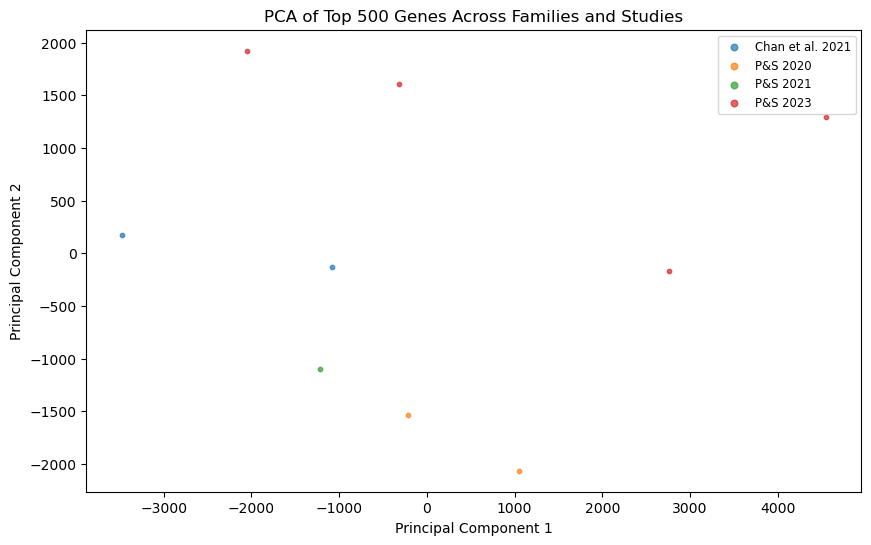

In [ ]:
### 5. PCA Analysis ###
# Prepare data for PCA
pca_data = gene_differences[['Study', 'BREED'] + top_gene_names].dropna()
display(pca_data.shape)
# Extract numerical data only
X_pca = pca_data.iloc[:, 2:]  # Drop 'Study' and 'BREED' columns

# Perform PCA
pca = PCA(n_components=2)
pca_transformed = pca.fit_transform(X_pca)

# Add PCA results to dataframe
pca_data['PC1'] = pca_transformed[:, 0]
pca_data['PC2'] = pca_transformed[:, 1]

### 6. Plot PCA (Color by Study, but Keep BREED Info) ###
plt.figure(figsize=(10, 6))

# Plot each study separately, while keeping `BREED` info in the labels
for study, df in pca_data.groupby('Study'):
    plt.scatter(df['PC1'], df['PC2'], label=study, alpha=0.7, s=10)

plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.2f}% Variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.2f}% Variance)')

plt.title("PCA of Top 500 Genes Across Families and Studies")
plt.legend(loc='upper right', fontsize='small', markerscale=1.5, frameon=True)
plt.show()